<a href="https://colab.research.google.com/github/mrunallll/Aadhar-UID-extraction/blob/main/aadhar_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing necessary dependencies

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install ISR
!pip install pdf2image
!pip install img2pdf
!sudo apt-get install poppler-utils
!pip install regex

Importing required packages

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from PIL import Image
import pytesseract as ocr
from ISR.models import RRDN
from google.colab.patches import cv2_imshow
from pdf2image import convert_from_path
import img2pdf

#Flow
1. Extraction of Aadhar UID (unique ID/ 12 digit aadar number)
2. Verification of the 12 digit aadhar number
3. Secure masking of the 12 digit UID

Verhoeff Algorithm

In [ ]:
#Permutation Table 
permutation_table = (
    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
    (1, 5, 7, 6, 2, 8, 3, 0, 9, 4),
    (5, 8, 0, 3, 7, 9, 6, 1, 4, 2),
    (8, 9, 1, 6, 0, 4, 3, 5, 2, 7),
    (9, 4, 5, 3, 1, 2, 6, 8, 7, 0),
    (4, 2, 8, 6, 5, 7, 3, 9, 0, 1),
    (2, 7, 9, 3, 8, 0, 6, 4, 1, 5),
    (7, 0, 4, 6, 9, 1, 3, 2, 5, 8))

# Multiplication Table 
multiplication_table = (
    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
    (1, 2, 3, 4, 0, 6, 7, 8, 9, 5),
    (2, 3, 4, 0, 1, 7, 8, 9, 5, 6),
    (3, 4, 0, 1, 2, 8, 9, 5, 6, 7),
    (4, 0, 1, 2, 3, 9, 5, 6, 7, 8),
    (5, 9, 8, 7, 6, 0, 4, 3, 2, 1),
    (6, 5, 9, 8, 7, 1, 0, 4, 3, 2),
    (7, 6, 5, 9, 8, 2, 1, 0, 4, 3),
    (8, 7, 6, 5, 9, 3, 2, 1, 0, 4),
    (9, 8, 7, 6, 5, 4, 3, 2, 1, 0))


Validation using Checksum, valid UID will have checksum 0


In [ ]:
#Validation using Checksum, valid UID will have checksum 0

def compute_checksum(number):

    # transform number list
    number = tuple (int (n) for n in reversed(str (number)))
    
    # calculate checksum
    checksum = 0
    
    for i, n in enumerate(number):
        checksum = multiplication_table[checksum][permutation_table[i % 8][n]]
    
    return checksum

Search Possible UIDs with Bounding Boxes

In [ ]:
def Regex_Search(bounding_boxes):

  possible_UIDs = []
  Result = ""

  for character in range(len(bounding_boxes)):
    if len(bounding_boxes[character])!=0:
      Result += bounding_boxes[character][0]
    else:
      Result += '?'

  matches = [match.span() for match in re.finditer(r'\d{12}', Result, overlapped=True)]

  for match in matches :

    UID = int(Result[match[0]:match[1]])
    
    if compute_checksum(UID)==0 and UID%10000!=1947:
       possible_UIDs.append([UID,match[0]])

  possible_UIDs = np.array(possible_UIDs)
  return possible_UIDs

Loading Pretrained weights of ESRGAN  
(Enhanced Super Resolution Generative Adversarial Network)

Refer [this](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11133/Wang_ESRGAN_Enhanced_Super-Resolution_Generative_Adversarial_Networks_ECCVW_2018_paper.pdf) for the original paper on ESRGAN

In [ ]:
 srgan=RRDN(weights='gans')

Secure Masking of the UID

In [ ]:
# Mask found UIDs using OpenCV

def Mask_UIDs (image_path, possible_UIDs, bounding_boxes, rtype, SR=False, SR_Ratio=[1,1]):

  img = cv2.imread(image_path)

  if rtype==2:
    img = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)
  elif rtype==3:
    img = cv2.rotate(img,cv2.ROTATE_180)
  elif rtype==4:
    img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)

  height = img.shape[0]

  if SR==True:
    height*=SR_Ratio[1]

  for UID in possible_UIDs:

    digit1 = bounding_boxes[UID[1]].split()
    digit8 = bounding_boxes[UID[1] + 7].split()

    h1 = min(height-int(digit1[4]),height-int(digit8[4]))
    h2 = max(height-int(digit1[2]),height-int(digit8[2]))

    if SR==False:
      top_left_corner = (int(digit1[1]),h1)
      bottom_right_corner = (int(digit8[3]),h2)

    else:
      top_left_corner = (int(int(digit1[1])/SR_Ratio[0]),int((h1)/SR_Ratio[1]))
      bottom_right_corner = (int(int(digit8[3])/SR_Ratio[0]),int((h2)/SR_Ratio[1]))

    img = cv2.rectangle(img,top_left_corner,bottom_right_corner,(0,0,0),-1)

  if rtype==2:
    img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
  elif rtype==3:
    img = cv2.rotate(img,cv2.ROTATE_180)
  elif rtype==4:
    img = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)

  file_name = image_path.split('/')[-1].split('.')[0]+"_masked"+"."+image_path.split('.')[-1]
  cv2.imwrite(file_name,img)
  return file_name

In [ ]:
# Extract, Verify and Mask UIDs

def Extract_and_Mask_UIDs (image_path, SR=False, sr_image_path=None, SR_Ratio=[1,1]):

  if SR==False:
    img = cv2.imread(image_path)
  else:
    img = cv2.imread(sr_image_path)

  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  rotations = [[gray,1],
               [cv2.rotate(gray,cv2.ROTATE_90_COUNTERCLOCKWISE),2],
               [cv2.rotate(gray,cv2.ROTATE_180),3],
               [cv2.rotate(gray,cv2.ROTATE_90_CLOCKWISE),4],
               [cv2.GaussianBlur(gray,(5,5),0),1],
               [cv2.GaussianBlur(cv2.rotate(gray,cv2.ROTATE_90_COUNTERCLOCKWISE),(5,5),0),2],
               [cv2.GaussianBlur(cv2.rotate(gray,cv2.ROTATE_180),(5,5),0),3],
               [cv2.GaussianBlur(cv2.rotate(gray,cv2.ROTATE_90_CLOCKWISE),(5,5),0),4]]

  settings = ('-l eng --oem 3 --psm 11')

  for rotation in rotations :
    
    cv2.imwrite('rotated_grayscale.png',rotation[0])
    bounding_boxes = ocr.image_to_boxes(Image.open('rotated_grayscale.png'),config=settings).split(" 0\n")

    possible_UIDs = Regex_Search(bounding_boxes)

    if len(possible_UIDs)==0:
      continue
    else:

      if SR==False:
        masked_img = Mask_UIDs (image_path,possible_UIDs,bounding_boxes,rotation[1])
      else:
        masked_img = Mask_UIDs (image_path,possible_UIDs,bounding_boxes,rotation[1],True,SR_Ratio)

      return (masked_img,possible_UIDs)

  return (None,None)

In [ ]:
# Test on an Image/PDF

input_path = "/content/501562435.jpg"   # Path to the Input Image/PDF

if input_path.split('.')[-1]=="pdf":
    
    pages = convert_from_path(input_path, 300)
    pages[0].save('pdf2img.jpg', 'JPEG')

if input_path.split('.')[-1]=="pdf":
  masked_img,possible_UIDs = Extract_and_Mask_UIDs('pdf2img.jpg')
else:
  masked_img,possible_UIDs = Extract_and_Mask_UIDs(input_path)

if masked_img!=None and input_path.split('.')[-1]=="pdf":
    
  image = Image.open(masked_img) 
  pdf_bytes = img2pdf.convert(image.filename) 
  file = open(input_path.split('/')[-1].split('.')[0]+"_masked"+".pdf", "wb")
  masked_img = input_path.split('/')[-1].split('.')[0]+"_masked"+".pdf" 
  file.write(pdf_bytes) 
  image.close() 
  file.close() 

if masked_img==None:
  print("Can't find any UID!")
else:
  print("Found Aadhar ID (UIDs) : "+str(possible_UIDs[:,0]))

Can't find any UID!


In [ ]:
# If it doesn't work, Try on Super Resolution Version 

input_path = "/content/501562435.jpg"   # Path to the Input Image/PDF

# Super Resolution using ESRGAN

if input_path.split('.')[-1]=="pdf":
    
    pages = convert_from_path(input_path, 300)
    pages[0].save('pdf2img.jpg', 'JPEG')

if input_path.split('.')[-1]=="pdf":
  LR_img = cv2.imread('pdf2img.jpg')
else:
  LR_img = cv2.imread(input_path)

SR_img = srgan.predict(LR_img[:,:,::-1])
cv2.imwrite("SR_img.png",SR_img[:,:,::-1])

SR_Ratio = [int(SR_img.shape[1]/LR_img.shape[1]),int(SR_img.shape[0]/LR_img.shape[0])]

if input_path.split('.')[-1]=="pdf":
  masked_img,possible_UIDs = Extract_and_Mask_UIDs('pdf2img.jpg',True,"SR_img.png",SR_Ratio)
else:
  masked_img,possible_UIDs = Extract_and_Mask_UIDs(input_path,True,"SR_img.png",SR_Ratio)

if masked_img!=None and input_path.split('.')[-1]=="pdf":
    
  image = Image.open(masked_img) 
  pdf_bytes = img2pdf.convert(image.filename) 
  file = open(input_path.split('/')[-1].split('.')[0]+"_masked"+".pdf", "wb") 
  masked_img = input_path.split('/')[-1].split('.')[0]+"_masked"+".pdf"
  file.write(pdf_bytes) 
  image.close() 
  file.close() 

if masked_img==None:
  print("Can't find any UID!")
else:
  print("Found UIDs : "+str(possible_UIDs[:,0]))

Found UIDs : [257258440930]


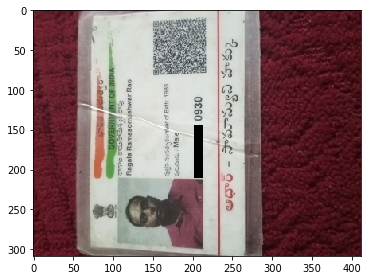

In [ ]:
from skimage import io
io.imshow(masked_img)